In [2]:
#AllLife Credit Card Customer Segmentation
#Background: AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

#Objective: To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

#Key Questions:
#1.	How many different segments of customers are there?
#2.	How are these segments different from each other?
#3.	What are your recommendations to the bank on how to better market to and service these customers?

In [14]:
import warnings

warnings.filterwarnings('ignore')

In [53]:
#numerical libraries
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from scipy.stats import zscore

#import panda to work with dataframe columns and rows
import pandas as pd

#import plotting libraries

import matplotlib.pyplot as plt
%matplotlib inline

#import seaborn for statistical plots
import seaborn as sns

from sklearn.metrics import silhouette_score



#Data Description: Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call.
#•	Customer key - Identifier for the customer
#•	Average Credit Limit - Average credit limit across all the credit cards
#•	Total credit cards - Total number of credit cards
#•	Total visits bank - Total number of bank visits
#•	Total visits online - total number of online visits
#•	Total calls made - Total number of calls made by the customer

In [16]:
#import data as dataframe
df = pd.read_csv("Credit Card Customer Data.csv")
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [17]:
df.shape  #check dataframe rows & columns

(660, 7)

In [18]:
#remove ID/customer key columns
df.drop(columns={'Sl_No', 'Customer Key'}, axis=1, inplace=True)

In [19]:
df.info()  #check data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


In [20]:
df.isnull().sum()  #check for missing values

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<AxesSubplot:>

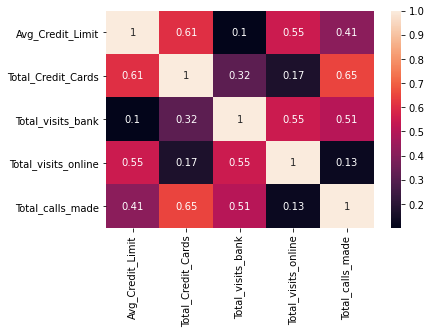

In [21]:
#check correlation matrix
cor = abs(df.corr())
sns.heatmap(cor, annot=True)  


In [22]:
#identify/list highly correlated variables
cor.loc[:, :] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.5) | (cor < -0.5)]

#We do not have any high values in correlations (>85) and will not drop any variables.  
#There aree no significant correlations observed among the different features as also demonstrated in our
#correlation heatmap

Total_Credit_Cards   Avg_Credit_Limit      0.608860
Total_visits_online  Avg_Credit_Limit      0.551385
                     Total_visits_bank     0.551861
Total_calls_made     Total_Credit_Cards    0.651251
                     Total_visits_bank     0.506016
dtype: float64

In [23]:
#generate descriptive statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


In [24]:
#Avg credit limit, total visits online and total calls made are positively skewed 
#Total credit cards and total visits to the bank are more normalized. 

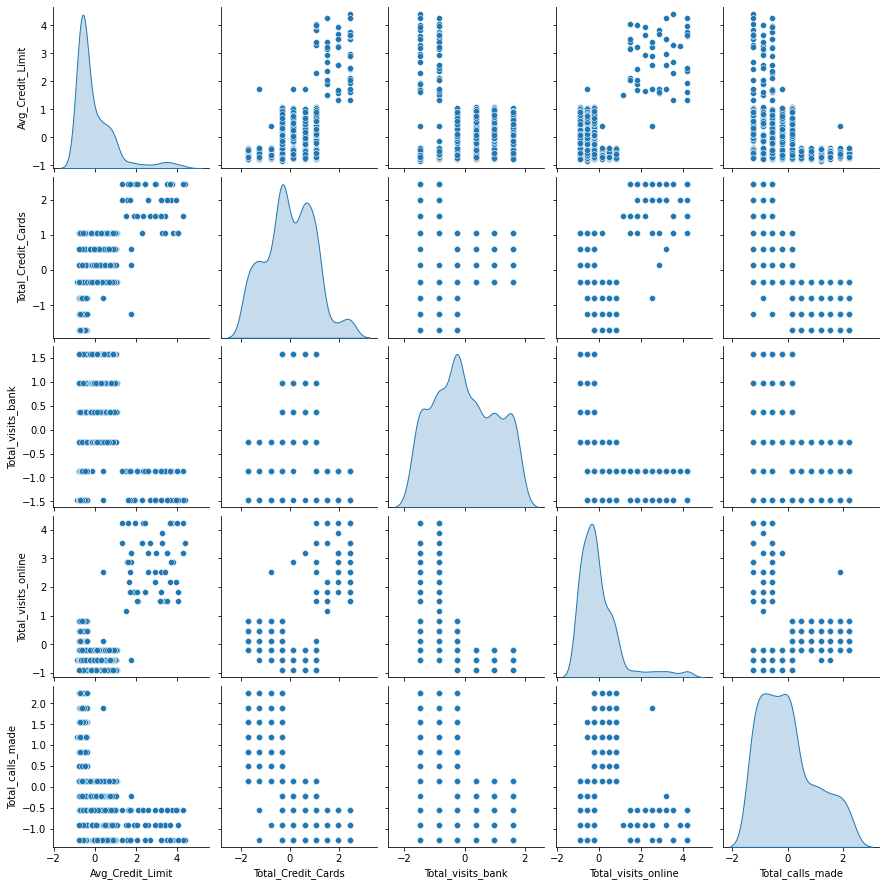

In [25]:
#create a pairplot of scaled data
dfScaled = df.apply(zscore)

sns.pairplot(dfScaled, diag_kind='kde')

#From the diagonal of the pairplot we can assume the data to be a mixture of gaussians, 
#by the peaks of the gaussians, we can expect an optimal number between 2 & 3.

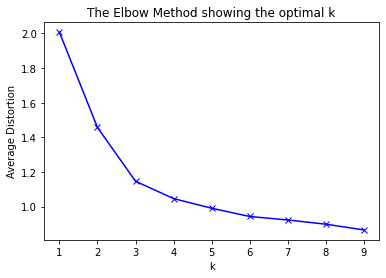

In [26]:
#we will use elbow method to find the exact number of clusters
from scipy.spatial.distance import cdist

clusters = range(1, 10)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(dfScaled)
    prediction = model.predict(dfScaled)
    meanDistortions.append(
        sum(
            np.min(cdist(dfScaled, model.cluster_centers_, 'euclidean'),
                   axis=1)) / dfScaled.shape[0])

    # Plot the elbow
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [27]:
#according to elbow graph, we will set number of clusters to 3

kmeans = KMeans(n_clusters=3, n_init=15, random_state=2345)

kmeans.fit(dfScaled)

KMeans(n_clusters=3, n_init=15, random_state=2345)

In [28]:
#calculate centroids and generate their values
centroids = kmeans.cluster_centers_
centroids

array([[-0.59579625, -1.05962278, -0.9015185 ,  0.32299678,  1.14810882],
       [-0.02106178,  0.37368962,  0.6663945 , -0.55367163, -0.55300488],
       [ 2.83176409,  1.86222621, -1.10576269,  2.82731942, -0.87432983]])

In [29]:
#create centroid dataframe and print
CentroidDF = pd.DataFrame(centroids, columns = list(dfScaled))
CentroidDF  #these are the centroids for all clusters

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,-0.595796,-1.059623,-0.901518,0.322997,1.148109
1,-0.021062,0.373690,0.666395,-0.553672,-0.553005
2,2.831764,1.862226,-1.105763,2.827319,-0.874330


In [30]:
#Steps to follow:
#1.	Perform univariate analysis on the data to better understand the variables at your disposal and to get an idea about the no of clusters. Perform EDA, create visualizations to explore data. (10 marks)
#2.	Properly comment on the codes, provide explanations of the steps taken in the notebook and conclude your insights from the graphs. (5 marks)
#3.	Execute K-means clustering use elbow plot and analyse clusters using boxplot (10 marks)

In [35]:
## create a new data frame for label and convert to categorical variable

KMeansData = dfScaled[:]  #creating a copy of the data 

KMeansData['KmeansLabel']=kmeans.labels_

In [37]:
KMeansData.head()


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KmeansLabel
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,1
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,0
2,0.410293,1.058973,-0.860451,0.134290,0.145528,1
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,1
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,2


In [40]:
KMeansData['KmeansLabel'].value_counts()  #find the number of data points in each group/cluster

1    386
0    224
2     50
Name: KmeansLabel, dtype: int64

In [60]:
#create model with k=3
FinalModel = KMeans(3)
FinalModel.fit(KMeansData)
prediction = FinalModel.predict(KMeansData)

#append  prediction
KMeansData['Group'] = prediction
print("Groups Assigned: \n")
KMeansData[["Avg_Credit_Limit", "Group"]]

Groups Assigned: 



,Avg_Credit_Limit,Group
0,1.740187,1
1,0.410293,0
2,0.410293,1
3,-0.121665,1
4,1.740187,2
...,...,...
655,1.713589,2
656,1.314621,2
657,2.937092,2
658,3.655235,2


array([[<AxesSubplot:title={'center':'Avg_Credit_Limit'}, xlabel='[Group]'>,
        <AxesSubplot:title={'center':'KmeansLabel'}, xlabel='[Group]'>,
        <AxesSubplot:title={'center':'Total_Credit_Cards'}, xlabel='[Group]'>,
        <AxesSubplot:title={'center':'Total_calls_made'}, xlabel='[Group]'>],
       [<AxesSubplot:title={'center':'Total_visits_bank'}, xlabel='[Group]'>,
        <AxesSubplot:title={'center':'Total_visits_online'}, xlabel='[Group]'>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

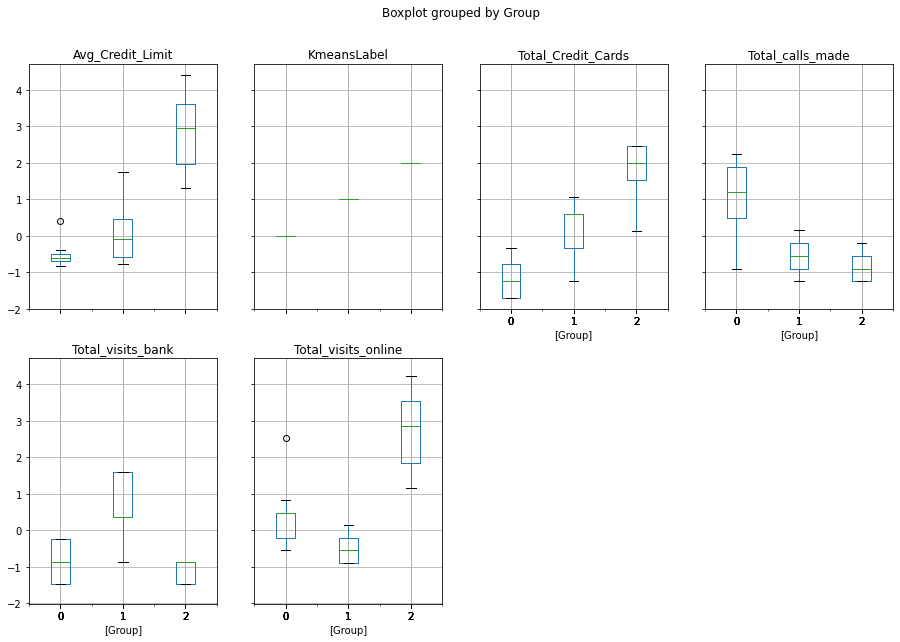

In [61]:
KMeansData.boxplot(by='Group', layout=(2, 4),
                   figsize=(15, 10))  #boxplot of all clusters

In [62]:
#Here we can observe that clients that have an average credit limit below 100,000 visit less online 
#an clients with average credit limit above 100,000 visit more online. 
#We can observe that clients that have an average credit limit above 100,000 visit the bank less
#than the clients who have an average credit limit less than 100,000 visit the bank more.

In [63]:
#to determine if there is a relationship between x and y (example)
KMeansData['Total_visits_bank'].corr(
    KMeansData['Total_visits_online'])  # this says no for these two variables

-0.5518614016610989

In [64]:
#we have a moderate inverse relationship between total visits to the bank and total visits online.
#groups who conduct business in the bank are less likely to visit the bank online/virtually

In [88]:
# Calculate & Print Silhoutte Score for KMeans
#
score = silhouette_score(KMeansData, FinalModel.labels_, metric='euclidean')

print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.560


In [89]:
#4.	Execute hierarchical clustering (with different linkages) with the help of dendrogram and cophenetic coeff.
#Analyse clusters formed using boxplot (15 marks)
#5.	Calculate average silhouette score for both methods. (5 marks)
#6.	Compare K-means clusters with Hierarchical clusters. (5 marks)
#7.	Analysis the clusters formed,
#tell us how is one cluster different from another and answer all the key questions. (10 marks)

In [90]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3,
                                affinity='euclidean',
                                linkage='average')
model.fit(dfScaled)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [91]:
#from scipy.cluster.hierarchy import dendrogram, linkage, cophenet and pdist from scipy
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

Z = linkage(dfScaled, metric='euclidean', method='average')
c, coph_dists = cophenet(Z, pdist(dfScaled))
c

0.8977080867389372

In [92]:
#we have a good cophenet index score

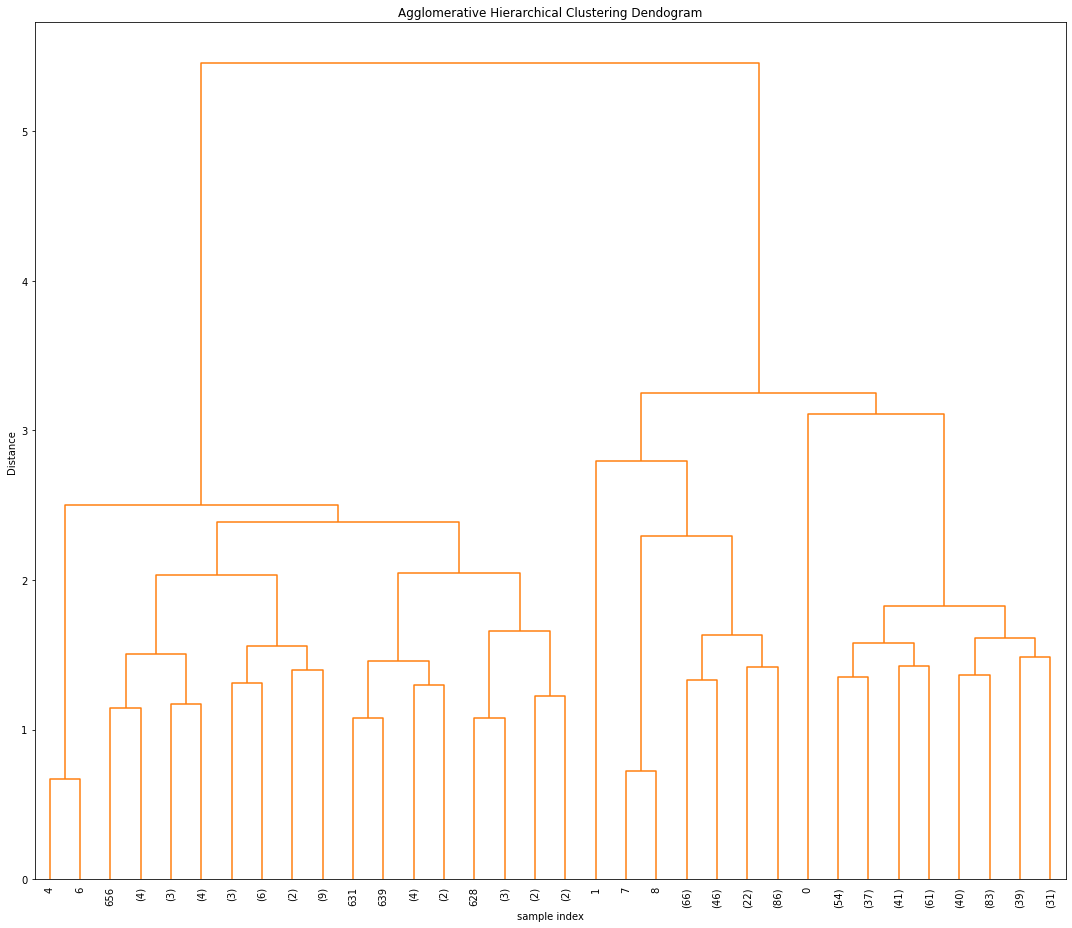

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 13))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z,
           leaf_rotation=90,
           p=5,
           color_threshold=40,
           leaf_font_size=10,
           truncate_mode='level')
plt.tight_layout()

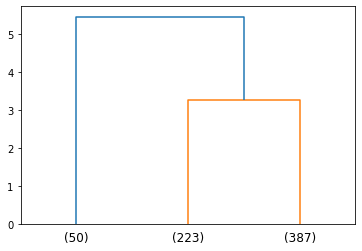

In [114]:
#find optimal distance
dendrogram(
    Z,
    truncate_mode='lastp',  #show only last p clusters
    p=3,  #show only the last p merged clusters    
)
plt.show()

#we have the same size clusters with both kmeans and hierarchical methods

In [134]:
#generate silhouette score
silhouette_score(dfScaled, clusters)

0.5703183487340514

In [ ]:
#Our silhouette score for KMeans is .60 and for the clusters is .57

In [ ]:
#By both the methods of Clustering we get comparable results
#Since both the clustering alogrithms are giving similar clusters 
#so we can assign labels from any one of the algorithm to the original 
#(non scaled) data to analyse clusters profiles 
#(here we are assigning labels of Kmeans , same could be done using hierarchical labels)

In [ ]:
#Key Questions:
#1.	How many different segments of customers are there?
#2.	How are these segments different from each other?
#3.	What are your recommendations to the bank on how to better market to and service these customers?

In [ ]:
#For our 3 segments/clusters of customers, we can see the following characteristics and recommend marketing strategies and service that involve their preferred method of contact:
#cluster 0 (224 data points) appears to prefer to conduct business in the bank, has the least online/web usage, lower credit card balances, few online visits and trips to the bank, but utilize the phone most often to contact the bank
#for cluster 0 we'd want to create marketing efforts that primarily utilize in-person/in-store strategies
#cluster 1 (386 data points) our largest group appears to have the most credit cards, highest average cc balances, least in bank visits and highest online/web use
#for cluster 1 we'd want to focus marketing/service approach using the web/internet
#cluster 2 (50 data points) our smallest group appears to use the telephone the most, have the fewest credit cards and lowest balances.
#for cluster 2, we'd want to use marketing strategies that primarily occur by phone